### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

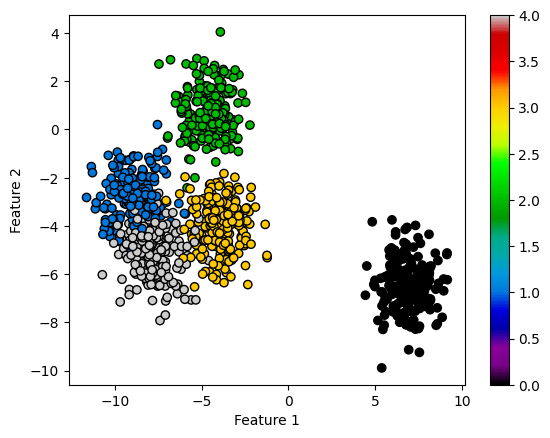

In [110]:
#Problem 1
#Load data
data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

#Sparate columns
feature1= data[:,0]
feature2= data[:,1]
label= data[:,2]

#Plotting
plt.scatter(feature1, feature2, 
            c=label, cmap="nipy_spectral", edgecolor="k")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

In [10]:
print(type(feature1))

<class 'numpy.ndarray'>


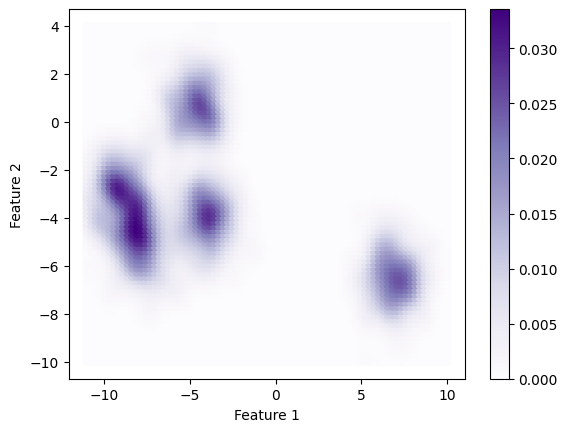

In [111]:
#Problem 2
#Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#Restructure data as one array
X= np.column_stack([feature1, feature2])


#Find optimal bandwidth
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 #5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Test each bandwidth
grid.fit(X) 
bw_opt = grid.best_params_['bandwidth']

#Run KDE with optimal bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=bw_opt)
kde.fit(X) #fit the model to the data

#Make grid and sample the KDE
u = np.linspace(-11,10, 80)
v = np.linspace(-10,4, 80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

#Plotting
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

SRT: Correct! Slight point deduction for not stating what the optimal bandwidth was. I know you use it, but always rememeber to answer the question. -1 point

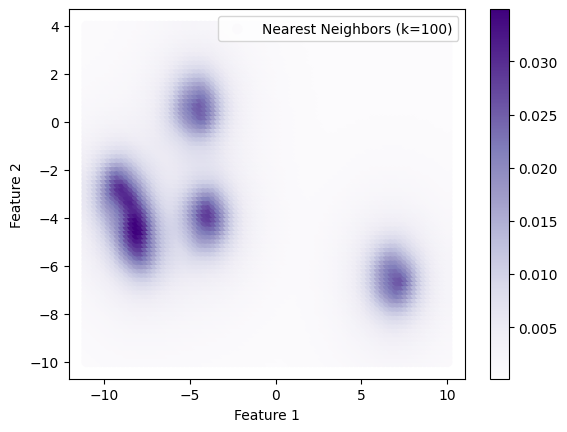

In [113]:
#Problem 3
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

# Compute density with Bayesian nearest neighbors
k=100 #This was about the best number of neighbors I found

#Create grid and sample KNN 
u = np.linspace(-11,10,80)
v = np.linspace(-10,4, 80)
X_grid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
dens_nbrs = nbrs.eval(X_grid)/len(X)

#PLotting
plt.scatter(X_grid[:,0], X_grid[:,1], c=dens_nbrs, cmap="Purples", lw=1.5, label="Nearest Neighbors (k=%i)" % k)
plt.colorbar()

# label the plot
plt.legend(loc='upper right')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

SRT: Looks good.

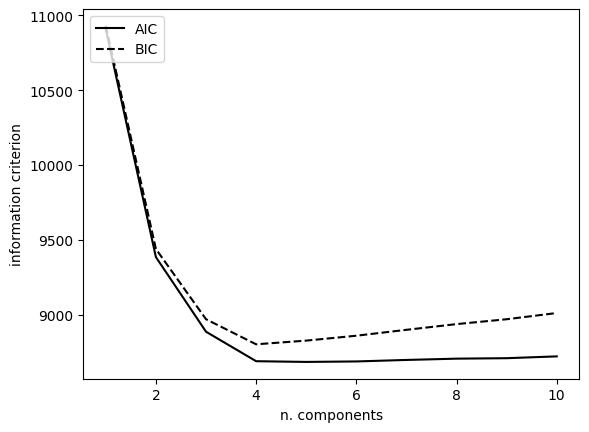

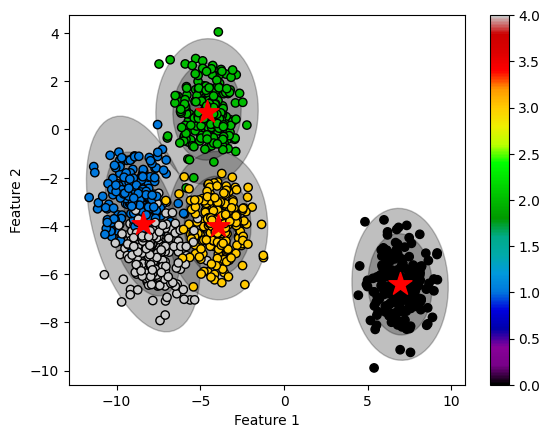

In [115]:
#Problem 4
from sklearn.mixture import GaussianMixture

# fit 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

#loop through number of components
for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#Plot results

#Plot AIC and BIC
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend(loc=2)
plt.show()

#GMM with optimal components (from BIC)
M_best = models[np.argmin(BIC)] #Model with lowest BIC (optimal model)

means= M_best.means_ #centers
covariances=M_best.covariances_ #covariance matrices

#Plotting 
for i in range(len(means)): #Loop through each center to plot ellipses
    C = covariances[i]  # Extract covariance matrix for component i
    draw_ellipse(means[i], C, scales=[1, 2, 3], alpha=0.25, color='black') 
plt.scatter(feature1, feature2, 
            c=label, cmap="nipy_spectral", edgecolor="k")
plt.colorbar()
plt.scatter(means[:,0], means[:,1], marker="*", c='red', s=300)#, edgecolors='white')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

SRT: Nicely done, Brayan.

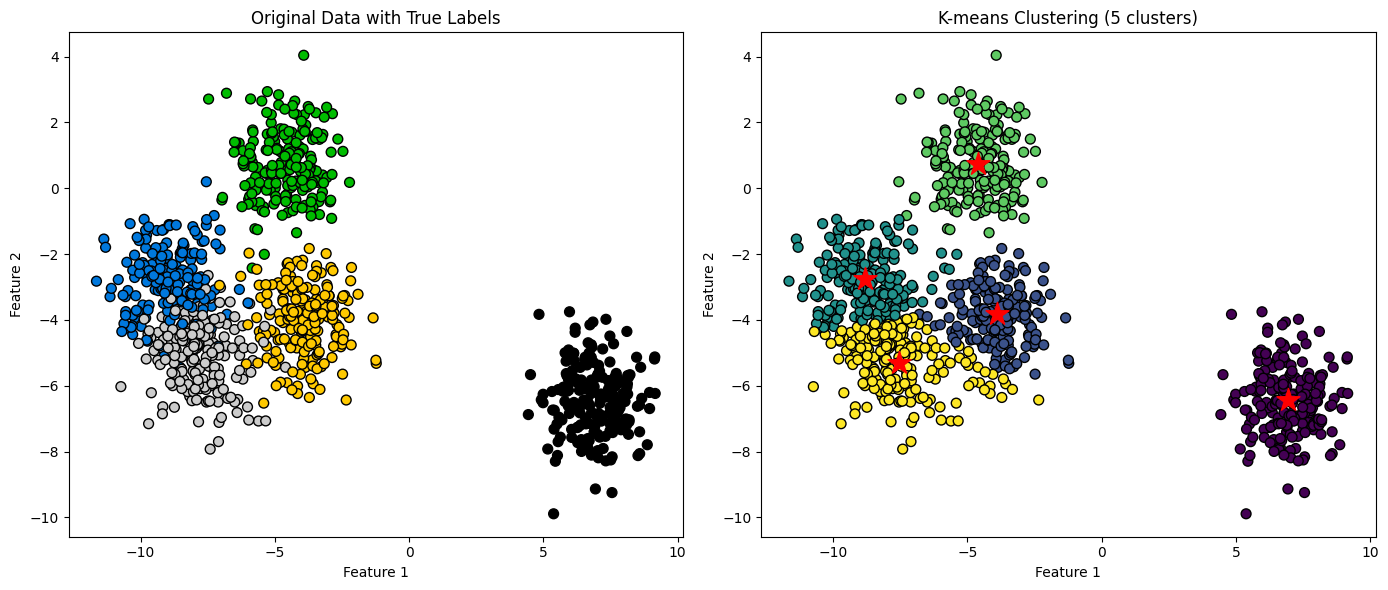

In [114]:
#Problem 5
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from matplotlib.patches import Patch

#Scale Data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#Fit Scaled Data
clf = KMeans(n_clusters=5)
clf.fit(X_std)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X_std) #labels for each of the points

#Find cluster centers and inverse transform them to original coordinates
cluster_centers_scaled = clf.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

#Predict labels for the scaled data
labels = clf.predict(X_std)


#Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#1st subplot: Original data with true labels
scatter1 = axes[0].scatter(feature1, feature2, c=label, cmap="nipy_spectral", edgecolor="k", s=50)
axes[0].set_title('Original Data with True Labels')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')


#2nd subplot: K-means clustering with cluster centers
scatter2 = axes[1].scatter(feature1, feature2, c=labels, cmap="viridis", edgecolor="k", s=50)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                c='red', marker='*', s=300, label='Cluster Centers')
axes[1].set_title('K-means Clustering (5 clusters)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()


SRT: Excellent

49/50